In [6]:
import sys
import os
root_path = "/mnt/brain5/scratch/wcarvalh/projects/rljax/"
sys.path.append(root_path)
print("Started")
print(os.getcwd())

Started
/mnt/brain5/scratch/wcarvalh/projects/rljax/analysis


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# Get directories

In [154]:
from glob import glob
from pprint import pprint

def single_path(path_search):
  options = glob(path_search)
  assert len(options) == 1, f'ambiguous/empty: {path_search}, {str(options)}'
  return options[0]


basepath = 'results/msf/final'
searches = dict(
      usfa='baselines3/*usfa,*', # 
      msf='relate_ablate4/*rel*', # model, not relational
      usfa_lstm='baselines3/*usfa_lstm,*', # 
      uvfa='baselines3/*r2d1*', # 
    )

directories = []
for agent, agent_search in searches.items():
    path_search = os.path.join(root_path, basepath, agent_search)
    path = single_path(path_search)

    seed_paths = glob(os.path.join(path, "seed=*"))
    seed_paths.sort()

    cuda_idx = 0
    for seed_path in seed_paths:
        directories.append(seed_path)


pprint(directories)

['/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/baselines3/agen=usfa,sett=large_respawn/seed=1',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/baselines3/agen=usfa,sett=large_respawn/seed=2',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/relate_ablate4/agen=msf,sett=large_respawn,sf_n=relational,modu=2/seed=1',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/relate_ablate4/agen=msf,sett=large_respawn,sf_n=relational,modu=2/seed=2',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/relate_ablate4/agen=msf,sett=large_respawn,sf_n=relational,modu=2/seed=3',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/baselines3/agen=usfa_lstm,sett=large_respawn/seed=1',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/baselines3/agen=usfa_lstm,sett=large_respawn/seed=2',
 '/mnt/brain5/scratch/wcarvalh/projects/rljax/results/msf/final/baselines3/agen=r2d1,sett=large_respawn/seed=1',
 '/mnt/b

In [155]:
import pandas as pd
def csv_path(path):
    csv_path = os.path.join(path, 'evaluation', 'eval_return_counts.csv')
    assert os.path.exists(csv_path), f'no file in: {path}'
    return csv_path

def open_csv(path):
    csv_file = csv_path(path)
    return pd.read_csv(csv_file, usecols=['level', 'agent', 'episode_return', 'object0', 'object1', 'object2', 'object3'])

dfs = []
for d in directories:
    try:
        df = open_csv(d)
        dfs.append(df)
    except Exception as e:
        print(e)
        continue
        
# dfs = [open_csv(d) for d in directories]

df = pd.concat(dfs)

In [156]:
# df.groupby(['level', 'agent']).mean().round(decimals=1)

In [157]:
levels = df['level'].unique()
levels

array(['-1,1,-1,1', '-1,-1,-1,-1', '-1,1,0,1', '0,0,1,0', '1,1,1,1',
       '0,1,0,0', '0,0,0,1', '1,0,0,0', '1,1,0,0', '-1,1,-1,-1'],
      dtype=object)

In [158]:
levels = {
    # '1,1,0,0': '1,1,0,0',
    '1,1,1,1': '1,1,1,1',
    '-1,1,0,1': '-1,1,0,1 (-)',
    '-1,1,-1,1': '-1,1,-1,1 (- -)',
    '-1,1,-1,-1': '-1,1,-1,-1, (- - -)',
    '-1,-1,-1,-1': '-1,-1,-1,-1 (- - - -)',
}

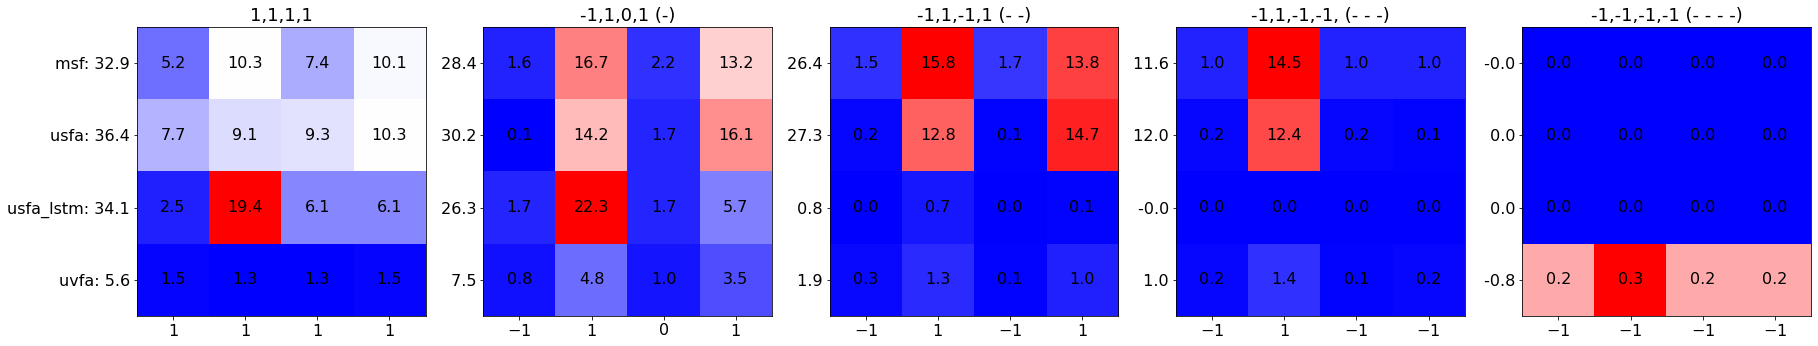

In [159]:
def format_name(name):
    if "msf" in name.lower(): new_name = name.replace(name, "MSFA")
    elif "usfa:" in name.lower(): new_name = name.replace(name, "USFA (Oracle)")
    elif "usfa_lstm" in name.lower(): new_name = name.replace(name, "USFA (LSTM)")
    elif "uvfa" in name.lower(): new_name = name.replace(name, "UVFA")
    else: raise RuntimeError(name)
    print(name, new_name)
    return new_name

def get_data(_df):
    counts = [_df[f'object{idx}'] for idx in range(4)]
    counts = np.array(counts).T
    returns = _df[f'episode_return']
    agents = _df['agent']

        # counts = grouped[[f'object{idx}' for idx in range(4)]]
    # counts.insert(0, 'agent', rows)

    label = lambda a, r: f"{a}: {r}"
    rows = [label(a,r) for a,r in zip(agents, returns)]
    # print(rows)
    return counts, rows
def xlab(l):
    if l == '1': return "$1$"
    elif l == '-1': return "$-1$"
    else: return l
def add_heatmap(ax, data, row_labels, level, title):
    ax.imshow(data, cmap = 'bwr' , interpolation = 'nearest')
    ax.set_title(title, fontsize=major_fs)
    
    if idx > 0:
        row_labels = [r.split(":")[1] for r in row_labels]
    # else:
    #     row_labels = [format_name(r) for r in row_labels]
    #     print(row_labels)
    ax.set_yticks(np.arange(len(row_labels)), labels=row_labels, fontsize=minor_fs)
        
    xlabels = level.split(",")
    xlabels = [xlab(l) for l in xlabels]
    ax.set_xticks(np.arange(len(xlabels)), labels=xlabels, fontsize=minor_fs)
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            text = ax.text(j, i, data[i, j],
                           ha="center", va="center", color="black", fontsize=minor_fs)


width=30
fig, axs = plt.subplots(1, len(levels), figsize=(width, width*len(levels)))

minor_fs = 16
major_fs = 18
for idx, (level, title) in enumerate(levels.items()):
    level_df = df[df['level']==level]
    grouped = level_df.groupby(['agent']).mean().round(decimals=1).reset_index()
    
    data, row_labels = get_data(grouped)
    
    ax = axs[idx]
    add_heatmap(ax, data, row_labels, level, title)

# Create colorbar
# cbar = ax.figure.colorbar(data, ax=ax, **cbar_kw)
#     cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
# texts = annotate_heatmap(im, valfmt="{x:.1f} t")

# data, row_labels

In [151]:
x = "msf: 32.9"
x.lower().replace('msf', 'MSFA')

'MSFA: 32.9'